In [8]:
import imgtda
from imgtda import standard_analysis as sa
from imgtda import computer_vision as cv

import numpy as np
import pandas as pd
from scipy import misc
from skimage import morphology as morph
from skimage import measure
import scipy
from skimage.feature import peak_local_max
from skimage.morphology import watershed
from scipy import ndimage as ndi
from PIL import Image
import PIL

from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.animation as animation

%matplotlib inline

plt.rcParams['figure.figsize'] = (10.0, 10.0) 

import warnings
warnings.filterwarnings('ignore')

## Set Up Project

In [9]:
myproject = imgtda.Project

myproject['directory'] = '/Users/birdbrain/Documents/Research/Projects/Schatz/Data/g21chaotic/r4000_2015_09_16_fast'
myproject['bmp_format'] = 'g21flow/bmps/%06d.bmp'
myproject['pd_sub_format'] = 'g21flow/pd_sub/%06d.csv'
myproject['pd_sup_format'] = 'g21flow/pd_sup/%06d.csv'
myproject['additional_data'] = {'lyap_format':'g21per/bmps_abs_val/%05d.bmp',
                                'delta':10,
                                'lyap_out_format':'g21per/bmps_abs_val_smooth_6/%05d.bmp',
                                'lyap_pdsub_format':'g21per/pd_sub_smooth_6/%05d.csv'}


## Utility Functions

In [10]:
def load_image_data(project, idx):
    
    im = imgtda.image.load_image_from_file(project['directory'] + "/" + (project['bmp_format'] % idx))
    im.load_sublevel_pd(project['directory'] + "/" + (project['pd_sub_format'] % idx))
    im.load_superlevel_pd(project['directory'] + "/" + (project['pd_sup_format'] % idx))
    return im

def load_lyap_data(project, idx):
    
    lyap = misc.imread(project['directory'] + "/" + (project['additional_data']['lyap_format'] % idx))
    return lyap

def load_lyap_pd_data(project, idx):
    
    lyap = pd.DataFrame(pd.read_csv(project['directory'] + "/" + (project['additional_data']['lyap_pdsub_format'] % idx)))
    return lyap

def cropping_region():

    c = np.zeros((421,421))
    centerx = 210
    centery = 210
    radius=200
    for i in range(c.shape[0]):
        for j in range(c.shape[1]):
            if ((i-centerx)**2 + (j-centery)**2 < radius**2):
                c[i,j] = 1
    c = c.astype(np.int)
    return c


def get_image_saddle_points(im, lowercutoff, uppercutoff, delta):
    
    # Generate persistent homology defect matrix
    ph_lower_saddles = im.persistence_diagrams['sub'].loc[(im.persistence_diagrams['sub']['dim']==0) & ((im.persistence_diagrams['sub']['death'] - im.persistence_diagrams['sub']['birth']) >= delta) & (im.persistence_diagrams['sub']['death']>=lowercutoff) & (im.persistence_diagrams['sub']['death']<=127)][['d_x','d_y']]
    ph_lower_saddles.columns = ['col', 'row']
    ph_tmp = im.persistence_diagrams['sub'].loc[(im.persistence_diagrams['sub']['dim']==1) & ((im.persistence_diagrams['sub']['death'] - im.persistence_diagrams['sub']['birth']) >= delta) & (im.persistence_diagrams['sub']['birth']>=lowercutoff) & (im.persistence_diagrams['sub']['birth']<=127)][['b_x','b_y']]
    ph_tmp.columns = ['col', 'row']
    ph_lower_saddles = pd.concat([ph_lower_saddles, ph_tmp])

    ph_upper_saddles = im.persistence_diagrams['sup'].loc[(im.persistence_diagrams['sup']['dim']==0) & ((im.persistence_diagrams['sup']['birth'] - im.persistence_diagrams['sup']['death']) >= delta) & (im.persistence_diagrams['sup']['death']>=127) & (im.persistence_diagrams['sup']['death']<=uppercutoff)][['d_x','d_y']]
    ph_upper_saddles.columns = ['col', 'row']
    ph_tmp = im.persistence_diagrams['sup'].loc[(im.persistence_diagrams['sup']['dim']==1) & ((im.persistence_diagrams['sup']['birth'] - im.persistence_diagrams['sup']['death']) >= delta) & (im.persistence_diagrams['sup']['birth']>=127) & (im.persistence_diagrams['sup']['birth']<=uppercutoff)][['b_x','b_y']]
    ph_tmp.columns = ['col', 'row']
    ph_upper_saddles = pd.concat([ph_upper_saddles, ph_tmp])
    
    saddle_points = pd.concat([ph_lower_saddles, ph_upper_saddles])
    
    saddle_matrix = np.zeros(im.bmp.shape)
    saddle_matrix[saddle_points['row'], saddle_points['col']] = 1

    return saddle_matrix


def get_image_plumes(im, lowercutoff, uppercutoff, delta):
    
    # Generate persistent homology defect matrix
    ph_lower_plumes = im.persistence_diagrams['sub'].loc[(im.persistence_diagrams['sub']['dim']==1) & ((im.persistence_diagrams['sub']['death'] - im.persistence_diagrams['sub']['birth']) >= delta) & (im.persistence_diagrams['sub']['death']<=uppercutoff) & (im.persistence_diagrams['sub']['birth']<=127)][['d_x','d_y']]
    ph_lower_plumes.columns = ['col', 'row']

    ph_upper_plumes = im.persistence_diagrams['sup'].loc[(im.persistence_diagrams['sup']['dim']==1) & ((im.persistence_diagrams['sup']['birth'] - im.persistence_diagrams['sup']['death']) >= delta) & (im.persistence_diagrams['sup']['birth']>=127) & (im.persistence_diagrams['sup']['death']>=lowercutoff)][['d_x','d_y']]
    ph_upper_plumes.columns = ['col', 'row']
    
    plumes = pd.concat([ph_lower_plumes, ph_upper_plumes])
    
    plume_matrix = np.zeros(im.bmp.shape)
    plume_matrix[plumes['row'], plumes['col']] = 1

    return plume_matrix

def get_image_defects(idx, sigma, lowercutoff, uppercutoff, delta):

    im = load_image_data(myproject, idx)
    
    im.generate_orientation_field(sigma,1)
    im.orientation_fields[sigma].topological_defects_list = sa.topological_defect_array_to_dataframe(im.orientation_fields[sigma].topological_defects)
    im.saddle_points = get_image_saddle_points(im, lowercutoff, uppercutoff, delta)
    im.plumes = get_image_plumes(im, lowercutoff, uppercutoff, delta)

    return im

def generate_smoothed_lyap(idx, lyap_sigma, lyap):
    
    lyap = scipy.ndimage.filters.gaussian_filter(lyap, sigma=lyap_sigma)*2.
    lyap[lyap>=1.] = 1.
    
    lyap = (lyap*255.).astype(np.int)
    
    c = cropping_region()
    lyap = np.multiply(lyap, c)
    
    misc.imsave(myproject['directory'] + "/" + (myproject['additional_data']['lyap_out_format'] % idx), lyap)
    
    return 1
    

## Preprocess data for animation

### Functions for processing

In [11]:
def get_td_velocities(current, prior, distance_cutoff):
    
    types = [1., -1.]
    
    current['velocity'] = distance_cutoff
    current['matchedid'] = -1
    

    if not prior.empty:
        for t in types:
            type_matches = cv.match_points(current.ix[current.type == t,['row', 'col']], prior.loc[prior.type == t,['row', 'col']], distance_cutoff)
            current.ix[current.type==t, 'velocity'] = type_matches[:,1]
            current.ix[current.type==t, 'matchedid'] = type_matches[:,0].astype(np.int)
            
    return current

def get_defect_regions(im, sigma, radius, wn_cutoff, wn_cutoff_low):
    
    # Return a list rather than a matrix for scatter plot with varying alphas.
    #topological_defects_dilated = morph.binary_dilation(im.orientation_fields[sigma].topological_defects, morph.disk(radius))
    
    saddle_points_dilated = morph.binary_dilation(im.saddle_points, morph.disk(radius))
    plumes_dilated = morph.binary_dilation(im.plumes, morph.disk(radius))
    all_ph_dilated = ((saddle_points_dilated+plumes_dilated)>0).astype(np.int)
    large_wn = (im.local_wavenumber >= wn_cutoff).astype(np.int)
    small_wn = (im.local_wavenumber <= wn_cutoff_low).astype(np.int)
        
    return (all_ph_dilated, large_wn, small_wn)

def compose(f, x, n):
    if n == 0:
        return x
    return compose(f, f(x), n - 1)

def log_plus_one(x):
    return np.log10(10.*x+1)

def compute_derivative(images, derivative):
    if derivative == 1:
        return abs(images[0] - images[1])  
    else: 
        return compute_derivative([compute_derivative(images,derivative-1), compute_derivative(images[1:],derivative-1)],1)


### Processing code

1000


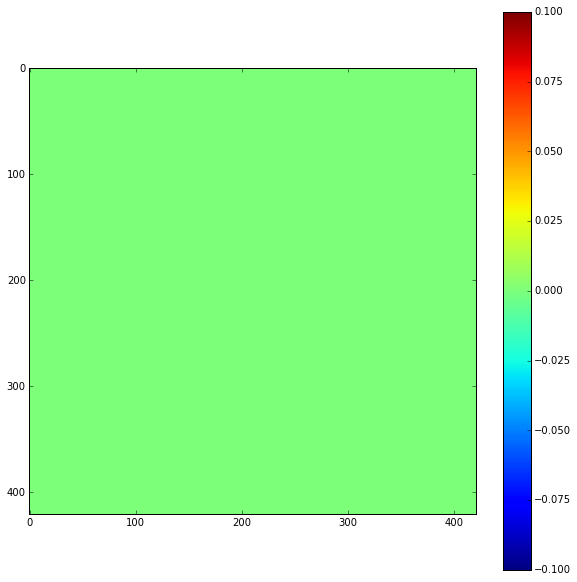

1001


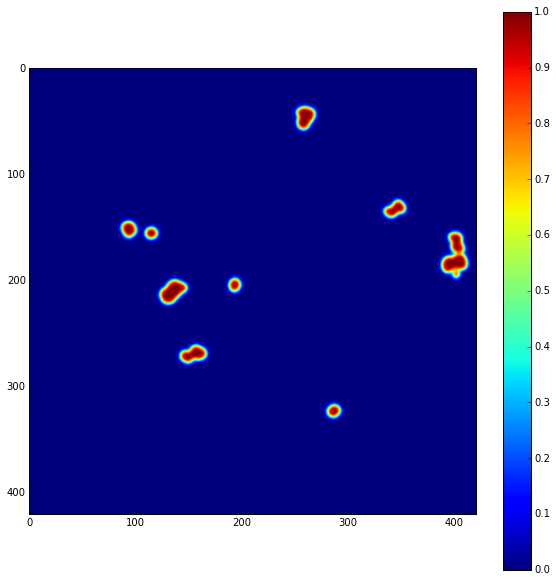

1002


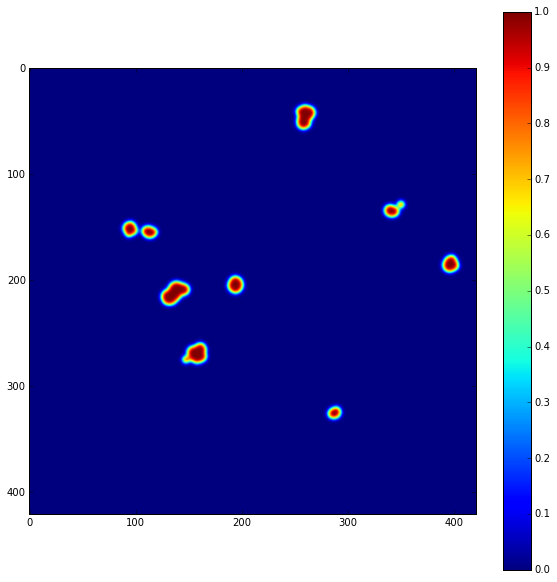

1003


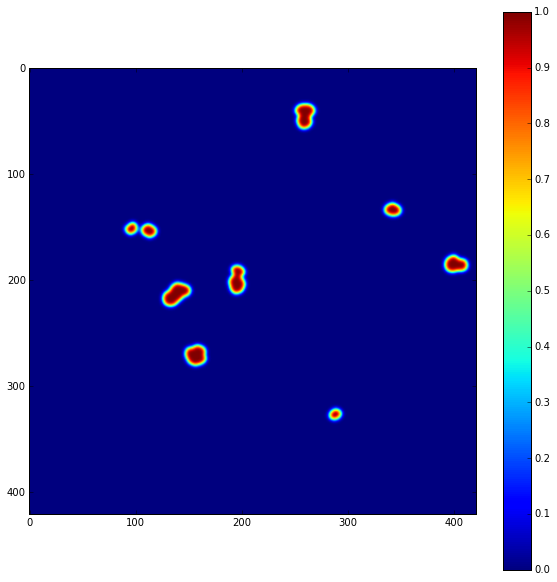

1004


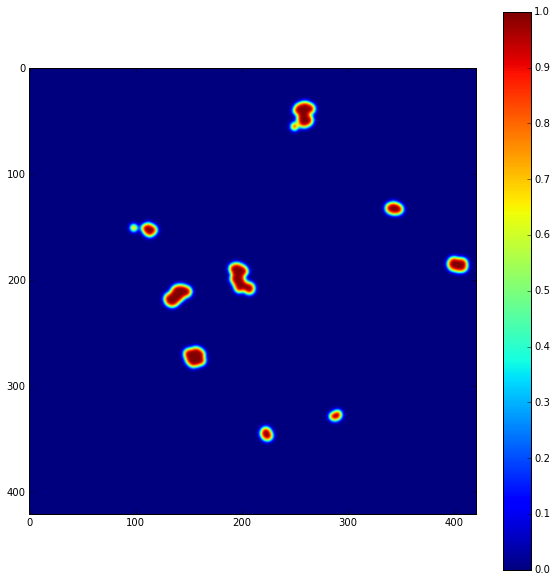

1005


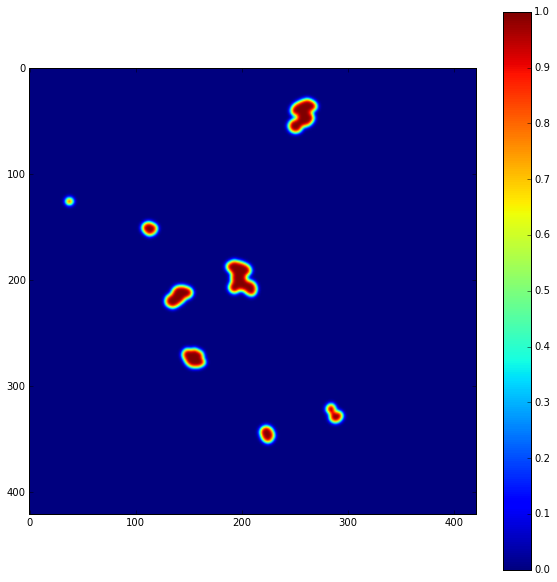

1006


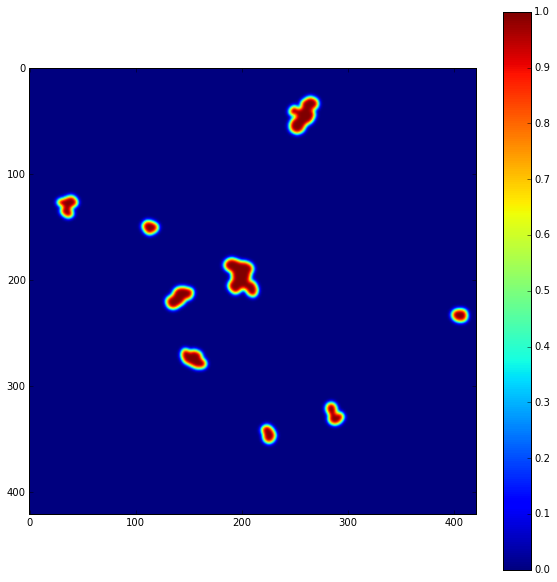

1007


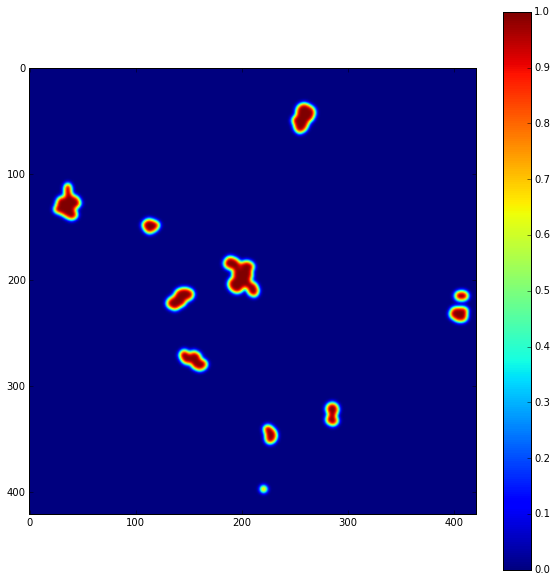

1008


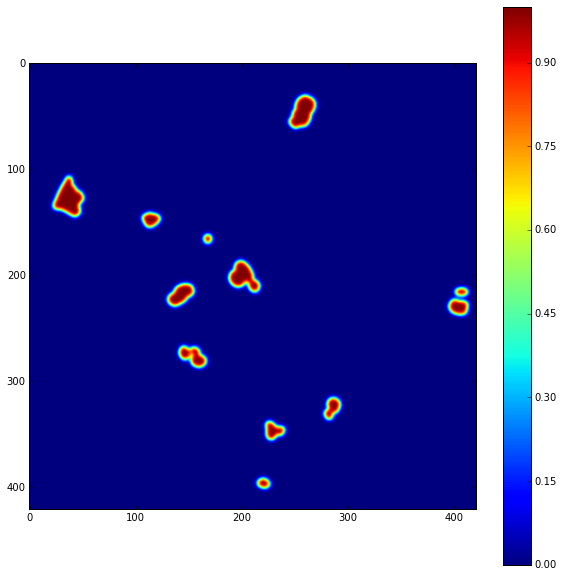

1009


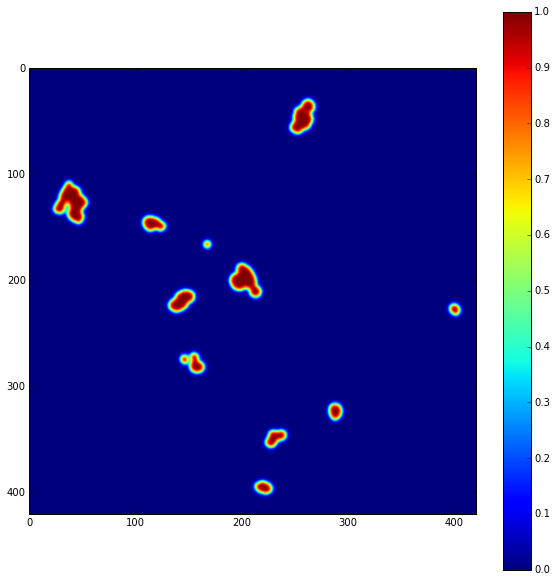

1010


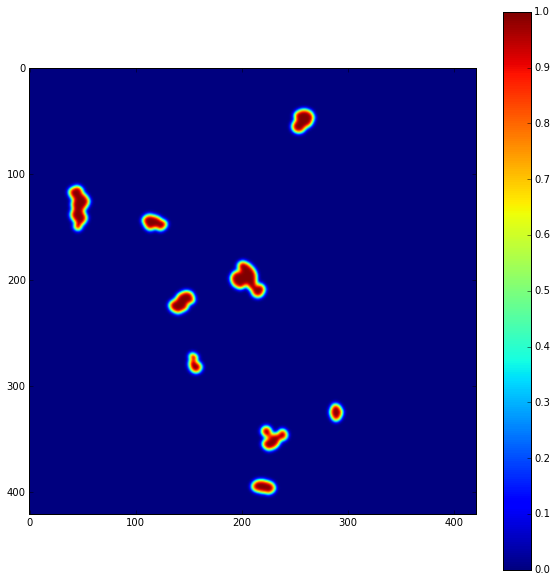

1011


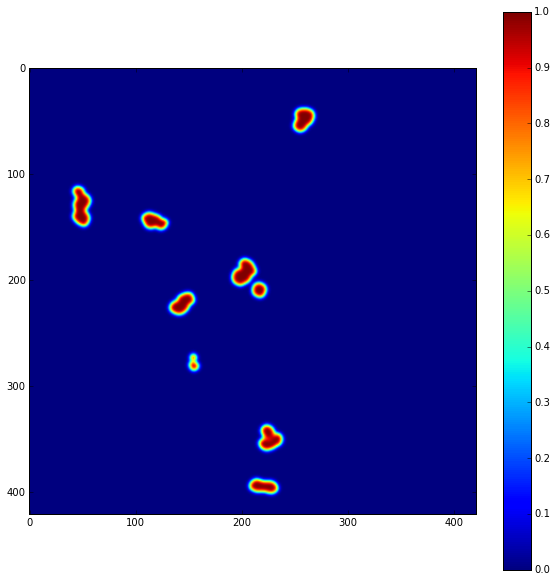

1012


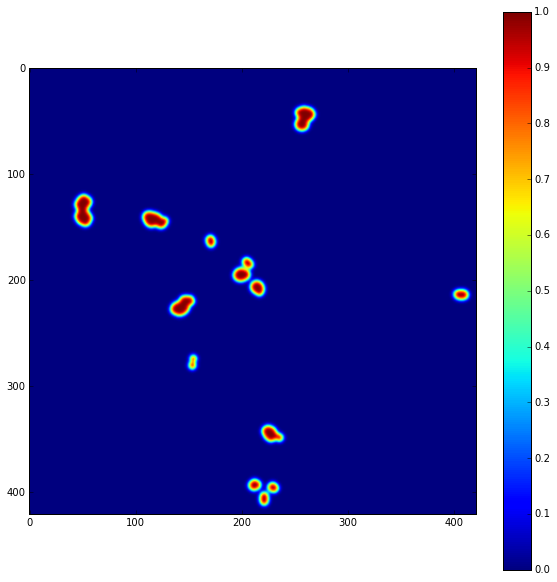

1013


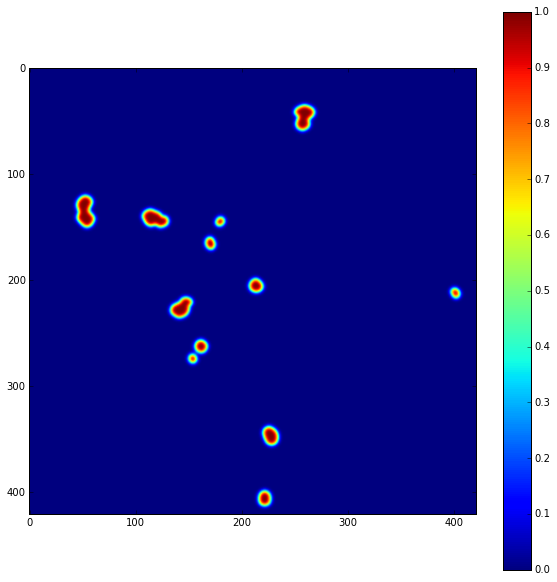

1014


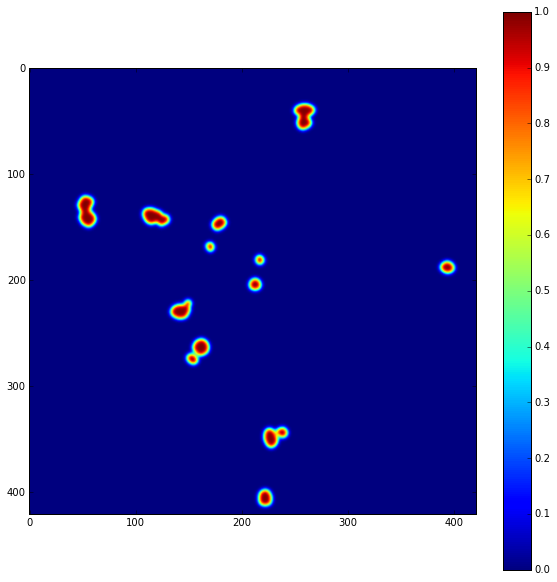

1015


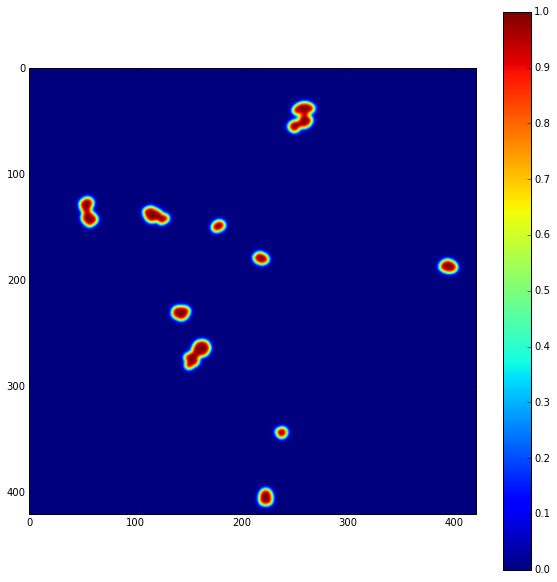

1016


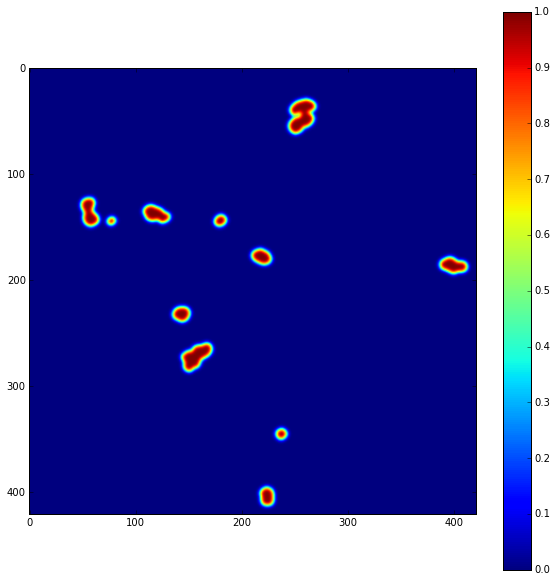

1017


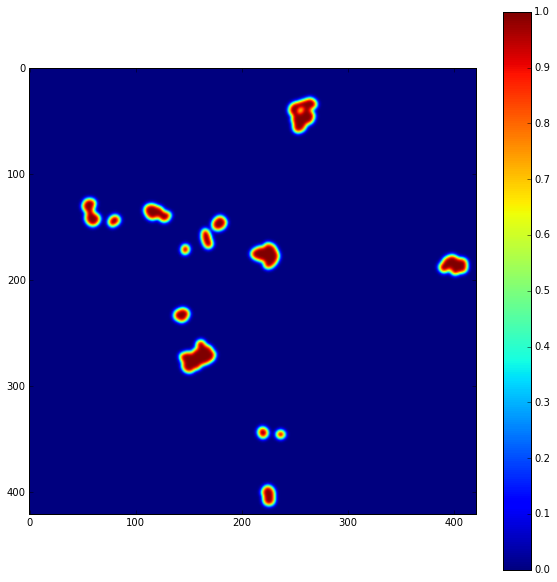

1018


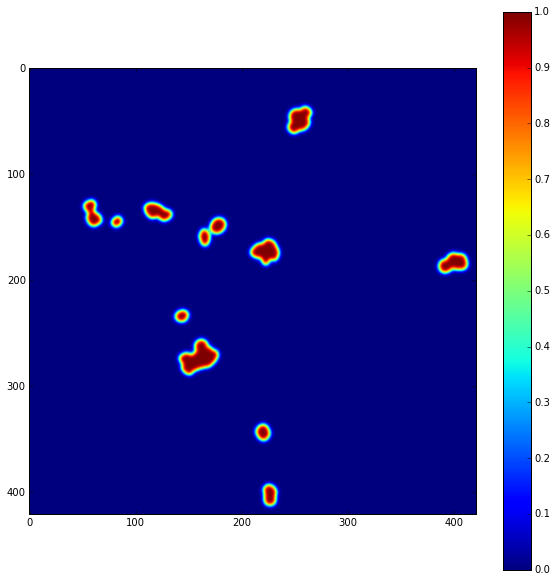

1019


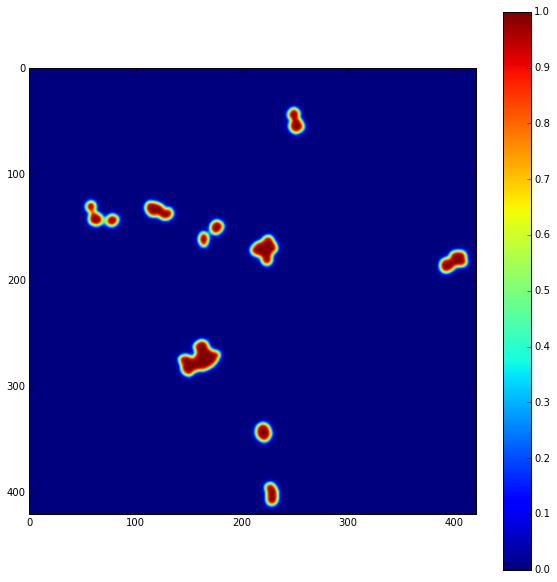

In [29]:
process_range = range(1000, 1020)

sigma = 3
radius = 10
lowercutoff = 45
uppercutoff = 200
delta = 10
wn_cutoff = 3.
wn_cutoff_low = 1.6
high_velocity = 5.

# Lyapunov peak selection
lyap_cutoff = 1.
lyap_peak_cutoff = 0.3
lyap_blur_radius = 12
lyap_diff_cutoff = 0.5
lyap_all_cutoff = 0.3
lyap_radius = 10

# Defect radii
defect_radius = 5

# Temperature derivative cutoffs
temp_derivative_cutoff = 20
temp_derivative = 1
temp_derivative_radius = 10


animation_data = {}
prev_td = pd.DataFrame([], columns=['row', 'col', 'type'])
prev_imgs = range(temp_derivative+1)
c = cropping_region()

for idx in process_range:
    
    print idx

    # Get all the stuff
    im = get_image_defects(idx, sigma, lowercutoff, uppercutoff, delta)
    im.local_wavenumber = sa.emb_wavenumber(im.bmp.astype(np.float), "difference", 10)*10.

    prev_imgs[0] = im.bmp.copy()

    if idx == process_range[0]:
        for derivative in range(1,temp_derivative+1):
            prev_imgs[derivative] =  im.bmp.copy()

    # Get indicator function for high velocities
    td_with_velocities = get_td_velocities(im.orientation_fields[sigma].topological_defects_list, prev_td, high_velocity)
    td_with_velocities = td_with_velocities.loc[(td_with_velocities['velocity'] >= high_velocity)]
    td_high_velocity_points = np.zeros(im.bmp.shape)
    td_high_velocity_points[td_with_velocities['row'], td_with_velocities['col']] = 1


    # Compute Lyapunov vector
    lyap = load_lyap_data(myproject, idx)
    lyap = lyap.astype(np.float)/255.
    lyap = np.multiply(lyap, c)

    # Compute Lyap peaks via difference of average peaks
    lyap_average = lyap.copy()
    kernel = np.zeros((lyap_blur_radius*2, lyap_blur_radius*2))
    kernel[lyap_blur_radius, lyap_blur_radius] = 1.
    kernel = morph.binary_dilation(morph.disk(lyap_blur_radius))
    lyap_average = scipy.ndimage.convolve(lyap_average, kernel, mode='constant', cval=0.0)
    lyap_diff = lyap - lyap_average/np.sum(kernel)
    
    divisor = lyap_average.copy()
    divisor[divisor <= 0.05] = 1
    lyap_diff = np.divide(lyap_diff, divisor)*100.
    lyap_diff = lyap_diff + (lyap>=lyap_peak_cutoff).astype(np.int)
    
    lyap_ind = (lyap_diff >= lyap_diff_cutoff).astype(np.int)
    lyap_ind = np.multiply(lyap_ind, lyap)
    lyap_ind = np.multiply(lyap_ind, c)
    
#     lyap_ind = (lyap_ind >= lyap_all_cutoff).astype(np.int)
    
    lyap_ind_smooth = ndi.filters.gaussian_filter(lyap_ind.astype(np.float), sigma=5)
    lyap_peaks = peak_local_max(lyap_ind_smooth, min_distance=10)
    
    
#     # Peaks of Lyapunov vector via a Gaussian blur
#     lyap_smoothed = ndi.filters.gaussian_filter(lyap, sigma=5)
#     lyap_peaks = peak_local_max(lyap_smoothed, min_distance=10)
    
    # Square root of Lyapunov vector to make more visible
    lyap = np.sqrt(lyap)
    
    # Get local derivatives of temperature field
    derivative_full = compute_derivative(prev_imgs, temp_derivative)
    derivative_ind = (derivative_full >= temp_derivative_cutoff).astype(np.int)
    
    
    derivative_full[derivative_full>=40.] = 40.
    derivative_full = derivative_full/40.

    # Crop everything into a circular region
    im.bmp = np.multiply(im.bmp, c)
    im.orientation_fields[sigma].topological_defects = np.multiply(im.orientation_fields[sigma].topological_defects, c)
    im.saddle_points = np.multiply(im.saddle_points, c)
    im.plumes = np.multiply(im.plumes, c)
    im.local_wavenumber[c == 0] = np.median(im.local_wavenumber[c == 1])
    lyap_ind = np.multiply(lyap_ind, c)
    td_high_velocity_points = np.multiply(td_high_velocity_points, c)
    
    derivative_ind = np.multiply(derivative_ind, c)
    derivative_ind = morph.binary_dilation(derivative_ind, morph.disk(3))
#     derivative_ind = morph.binary_erosion(derivative_ind, morph.disk(8))
#     derivative_ind = morph.binary_dilation(derivative_ind, morph.disk(3+temp_derivative_radius))
    
    derivative_full = np.multiply(derivative_full, c)
#     derivative_full = np.sqrt(derivative_full)
#     derivative_full[derivative_full<=0.5] = 0.
#     derivative_full = morph.dilation(morph.erosion(derivative_full, morph.disk(2)), morph.disk(2))
#     derivative_full = ndi.filters.gaussian_filter(derivative_full, sigma=5)
    
    # Get peaks in derivative function
    derivative_local_max = peak_local_max(ndi.filters.gaussian_filter(derivative_ind.astype(np.float), sigma=5), min_distance=2)
    
    
    plt.imshow(ndi.filters.gaussian_filter(derivative_ind.astype(np.float), sigma=2))
    plt.colorbar()
    plt.show()

    # Get the stuff to plot
    (ph, wn, wn_low) = get_defect_regions(im, sigma, radius, wn_cutoff, wn_cutoff_low)
    contours = measure.find_contours(im.bmp, 127.)
    
#     plt.imshow(np.multiply(l1_diff, c))
#     plt.colorbar()
#     plt.show()
    
#     plt.imshow(np.multiply(l2_diff, c))
#     plt.colorbar()
#     plt.show()
    
    animation_data[idx] = {'td': td_high_velocity_points, 
                           'ph': ph, 
                           'wn': wn, 
                           'wn_low': wn_low, 
                           'contours': contours, 
                           'lyap': lyap, 
                           'lyap_ind': lyap_ind, 
                           'lyap_peaks': lyap_peaks, 
                           'derivative_ind': derivative_ind, 
                           'derivative_full': derivative_full, 
                           'derivative_local_max': derivative_local_max}
    
    prev_td = im.orientation_fields[sigma].topological_defects_list.copy()
    prev_imgs[0] = im.bmp.copy()

    for derivative in reversed(range(1,temp_derivative+1)):
        prev_imgs[derivative] =  prev_imgs[derivative - 1].copy()

    del prev_td['velocity']
    del prev_td['matchedid']
    


## Animation code

In [32]:
def update_plot(ax, plot_data):
    
    plot_layers = []
    
#     matched_tds = plot_data['td'].loc[plot_data['td']['matchedid']>-1]
#     unmatched_tds = plot_data['td'].loc[plot_data['td']['matchedid']==-1]
    
#     # Matched topological defects
#     alphas_matched = matched_tds['velocity']
#     tda_colors_matched = np.zeros((matched_tds.shape[0],4))
#     tda_colors_matched[:,1] = 1
#     tda_colors_matched[:,2] = 1
#     tda_colors_matched[:,3] = (alphas_matched/distance_cutoff)*.6
#     plot_layers.append( [ax.scatter(matched_tds['col'], matched_tds['row'], s=900, color=tda_colors_matched)] )
    
#     # Unmatched topological defects
#     alphas_unmatched = unmatched_tds['velocity']
#     tda_colors_unmatched = np.zeros((unmatched_tds.shape[0],4))
#     tda_colors_unmatched[:,1] = 1
#     tda_colors_unmatched[:,2] = 1
#     tda_colors_unmatched[:,3] = (alphas_unmatched/distance_cutoff)*.6
#     plot_layers.append( [ax.scatter(unmatched_tds['col'], unmatched_tds['row'], s=900, color=tda_colors_unmatched, edgecolors='blue', linewidth=1) ])
    
#     # Lyapunov vector peaks only
#     alphas_lyap = plot_data['lyap_peaks']['value']
#     lyap_colors = np.zeros((plot_data['lyap_peaks'].shape[0],4))
#     lyap_colors[:,0] = 1
#     lyap_colors[:,1] = 1
#     lyap_colors[:,3] = .6
#     plot_layers.append( [ax.scatter(plot_data['lyap_peaks']['col'], plot_data['lyap_peaks']['row'], s=2800, color=lyap_colors) ])


#     # Lyapunov peak indicator function
#     lyap_color = np.dstack((np.ones(plot_data['lyap_ind'].shape), np.ones(plot_data['lyap_ind'].shape), np.zeros(plot_data['lyap_ind'].shape), (plot_data['lyap_ind'])*.75))
#     plot_layers.append( [ax.imshow(lyap_color, interpolation='nearest') ])

    # Lyapunov peaks local maxima
    if not plot_data['lyap_peaks'] == []:
        plot_layers.append( [ax.scatter(plot_data['lyap_peaks'][:, 1], plot_data['lyap_peaks'][:, 0], s=900, color='yellow')] )


    # Derivative full
    deriv_color = np.dstack((np.ones(plot_data['derivative_full'].shape), np.ones(plot_data['derivative_full'].shape), np.zeros(plot_data['derivative_full'].shape), (plot_data['derivative_full'])*.7))
    plot_layers.append( [ax.imshow(deriv_color, interpolation='nearest') ])
    
#     # Full Lyapunov vector
#     lyap_color = np.dstack((np.ones(plot_data['lyap'].shape), np.ones(plot_data['lyap'].shape), np.ones(plot_data['lyap'].shape), (1-plot_data['lyap'])*.9))
#     plot_layers.append( [ax.imshow(lyap_color, interpolation='nearest') ])

    
    # Derivative local maxima
    if not plot_data['derivative_local_max'] == []:
        plot_layers.append( [ax.scatter(plot_data['derivative_local_max'][:, 1], plot_data['derivative_local_max'][:, 0], s=900, alpha=0.3)] )

    
#     # Persistent homology points
#     colors_ph = [(1, 1, 1), (1, 1, 0)] 
#     cmap_name = 'w_ph'
#     cmap_ph = LinearSegmentedColormap.from_list(
#             cmap_name, colors_ph, N=2)
#     plot_layers.append( [ax.imshow(plot_data['ph'], alpha=.6, cmap=cmap_ph, interpolation='nearest') ])
    
#     # High wavenumber
#     colors_wn = [(1, 1, 1), (1, 0, 0)] 
#     cmap_name = 'w_wn'
#     cmap_wn = LinearSegmentedColormap.from_list(
#             cmap_name, colors_wn, N=2)
#     plot_layers.append( [ax.imshow(plot_data['wn'], alpha=.3, cmap=cmap_wn, interpolation='nearest') ])

#     # Low wavenumber
#     colors_wn_low = [(1, 1, 1), (1, 0, 1)] 
#     cmap_name = 'w_wn_low'
#     cmap_wn_low = LinearSegmentedColormap.from_list(
#             cmap_name, colors_wn_low, N=2)
#     plot_layers.append( [ax.imshow(plot_data['wn_low'], alpha=.3, cmap=cmap_wn_low, interpolation='nearest') ])
    
    stitle = ""


    plot_contours = []
    for n, contour in enumerate(plot_data['contours']):
        pc = ax.plot(contour[:, 1], contour[:, 0], linewidth=1, color='black')
        plot_contours.append(pc)

    return (plot_layers, plot_contours, stitle)
    

1000
1001
1002
1003
1004
1005
1006
1007
1008
1009
1010
1011
1012
1013
1014
1015
1016
1017
1018
1019


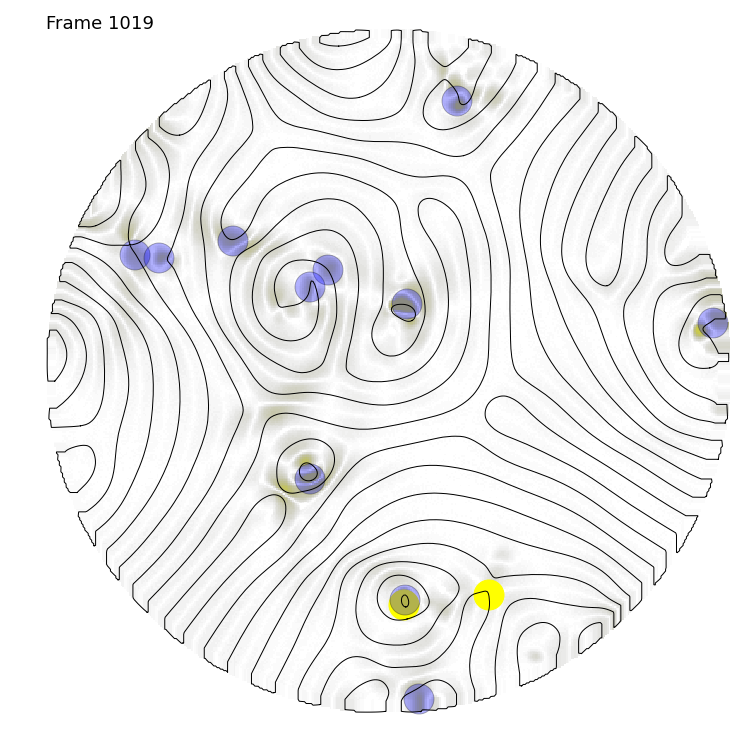

In [33]:
plt.rcParams['figure.figsize'] = (10.0, 10.0) 
fig = plt.figure();
ax = fig.add_subplot(111);
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None);
fig.gca().set_axis_off()

ax.set_xlim([0,im.bmp.shape[0]])
ax.set_ylim([im.bmp.shape[0], 0])

ims = []

for idx in process_range:
    
    print idx

    (plot_layers, plot_contours, stitle) = update_plot(ax, animation_data[idx])
    
    txt_title = ax.annotate(("Frame %d" % idx) + stitle, (10,10), color='black', fontsize=18)
    ax.axis('off')
    ims.append( [layer[0] for layer in plot_layers] + [txt_title] + [contour[0] for contour in plot_contours])

writer = animation.FFMpegWriter(bitrate=5000, fps=10)
anim = animation.ArtistAnimation(fig, ims, blit=True, repeat_delay=350)
anim.save(myproject['directory'] + ('/lyap_cutoff_%0.2f_%d_%d.mp4' % (lyap_diff_cutoff, process_range[0], process_range[-1])), writer=writer)